In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from joblib import dump
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('milknew.csv')
df = df.rename({'Temprature':'temperature', 'Taste':'taste', 'Odor':'odor', 'Fat ': 'fat', 'Turbidity':'turbidity',\
               'Colour':'color', 'Grade':'grade'}, axis=1)
df.head(10)

,pH,temperature,taste,odor,fat,turbidity,color,grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium
5,6.6,37,1,1,1,1,255,high
6,5.5,45,1,0,1,1,250,low
7,4.5,60,0,1,1,1,250,low
8,8.1,66,1,0,1,1,255,low
9,6.7,45,1,1,0,0,247,medium


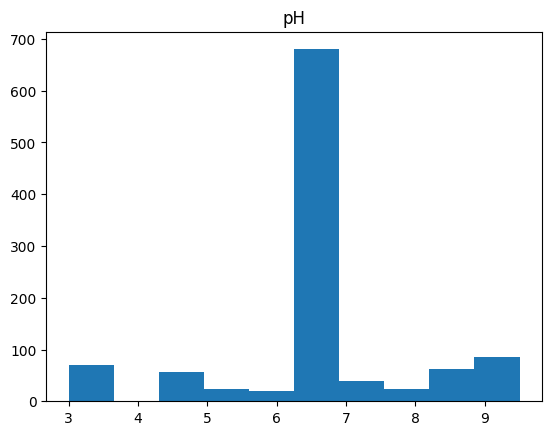

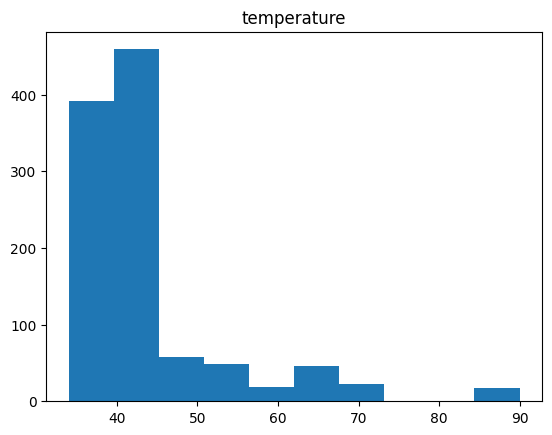

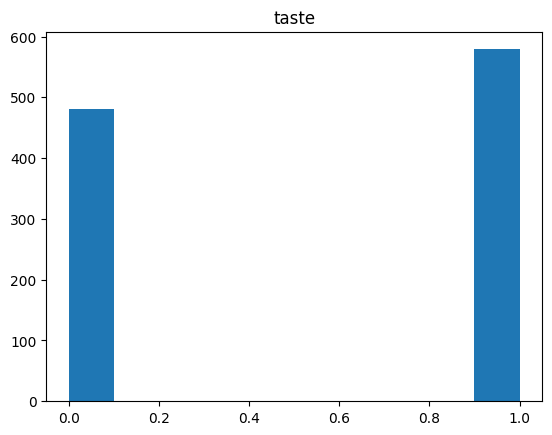

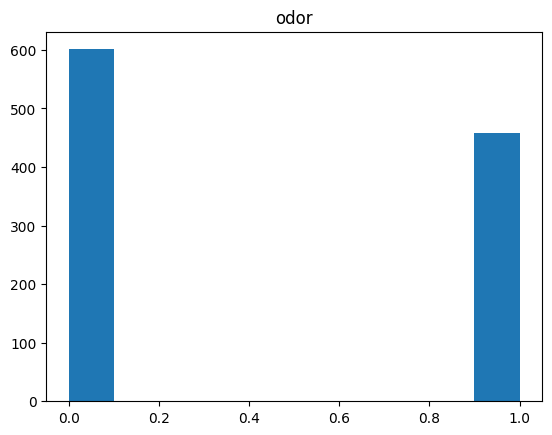

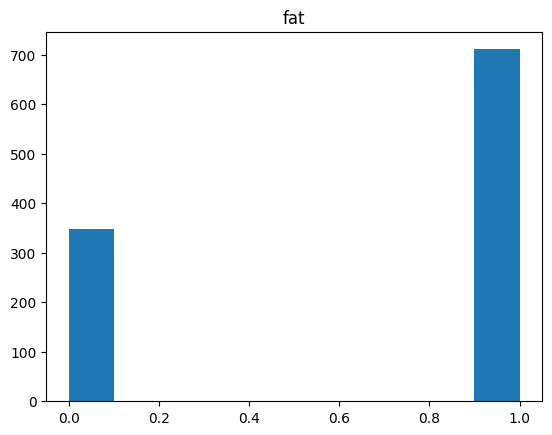

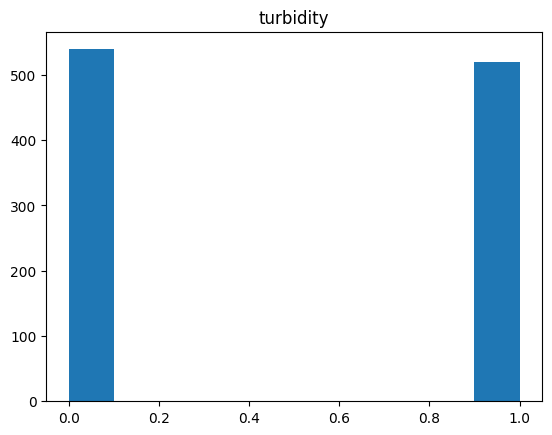

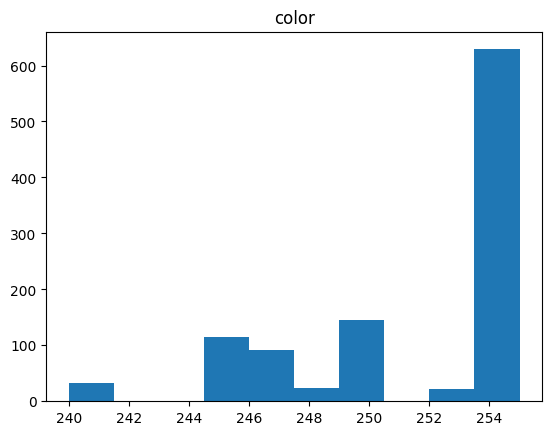

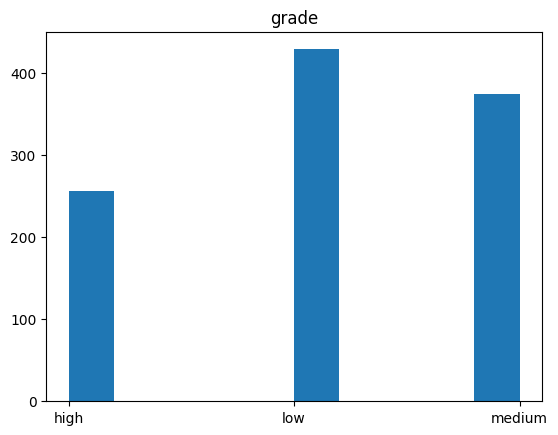

In [3]:
# Inspecting the distributions of each attribute.
# There are no null values in this dataframe, so no filling is needed.

for attr in df.columns:
    viz = df[attr]
    plt.hist(viz)
    plt.title(attr)
    plt.show() 

In [4]:
# Based on the symmetry of the data or its status as a categorical, mean, median, or mode 
# will be used later to fill blank prediction entries.

defaults = {}

# These attributes are binary and will be filled with their respective modes.
for attr in ['taste', 'odor', 'fat', 'turbidity']:
    defaults[attr] = df[attr].mode()[0]

# These attributes are asymmetrical and will be filled with their respective medians.
for attr in ['temperature', 'color']:
    defaults[attr] = df[attr].median()

# pH is symmetrical and will be filled with its mean.
defaults['pH'] = round(df['pH'].mean(), 2)

defaults

{'taste': 1,
 'odor': 0,
 'fat': 1,
 'turbidity': 0,
 'temperature': 41.0,
 'color': 255.0,
 'pH': 6.63}

In [5]:
# Splitting the data into train and test subsets. The shape verifies the expected outcomes. 
x, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10, shuffle=True)

print(x_train.shape, y_train.shape)

(847, 7) (847,)


In [6]:
# Stacked classifier ensemble approach. Finishes with a LogisticRegression model. 
estimators = [('gnb', GaussianNB()), 
              ('rf', RandomForestClassifier(n_estimators=10, random_state=10))]

ens = StackingClassifier(estimators=estimators)
ens.fit(x_train, y_train)
ens.score(x_test, y_test)

y_pred_ens = ens.predict(x_test)

accuracy_ens = metrics.accuracy_score(y_test, y_pred_ens)
f1_ens = f1_score(y_test, y_pred_ens, average='macro')
roc_ens = roc_auc_score(y, ens.predict_proba(x), multi_class='ovr')
print("accuracy: {} \nF1 score: {} \nROC score: {}".format(accuracy_ens, f1_ens, roc_ens))

accuracy: 0.9905660377358491 
F1 score: 0.9905143937305939 
ROC score: 0.9999951354296388


In [7]:
print(ens.predict([[6.6, 35,  1,  0,  1,  0,  254]])) 
print(ens.predict([[8.5, 70,  1,  1,  1,  1,  246]])) 

['high']
['low']


In [8]:
dump(ens, 'saved_model.joblib')
dump(defaults, 'saved_fill_values.joblib')

['saved_fill_values.joblib']